# LAB ML in DS: Project Part 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from statsmodels.graphics.gofplots import qqplot
from scipy.spatial import distance_matrix
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import shapiro, jarque_bera,norm 
from sklearn.utils import resample
import scipy.special
from joblib import Parallel, delayed
import time
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings(action="ignore")
pd.set_option('display.max_columns', None)

### 1.Loading the Data, Preprocessing, Initial Data Analysis

In [2]:
df=pd.read_csv(r"Wholesale customers data.csv")

In [3]:
df.shape

(440, 8)

In [4]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [6]:
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


The dataset contains information about spending behaviour of clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories.
###### Metadata
1)	FRESH: annual spending (m.u.) on fresh products (Continuous);<br>
2)	MILK: annual spending (m.u.) on milk products (Continuous);<br>
3)	GROCERY: annual spending (m.u.)on grocery products (Continuous);<br>
4)	FROZEN: annual spending (m.u.)on frozen products (Continuous)<br>
5)	DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous) <br>
6)	DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous); <br>
7)	CHANNEL: customers Channel - Horeca (Hotel/Restaurant/Cafe) or Retail channel (Nominal)<br>
8)	REGION: customers Region Lisnon, Oporto or Other (Nominal)<br>


The dataset contains 440 entries representing wholesale customers, with each entry detailing the customer's annual consumption in monetary units (m.u.) across various categories such as fresh, milk, grocery, frozen, detergents/paper, and delicatessen. Additionally, the dataset includes two geographic features, though these are initially excluded from the analysis.

In [7]:
df.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [8]:
df["Channel"].value_counts()  #1-Horeca, 2-Retail

Channel
1    298
2    142
Name: count, dtype: int64

In [9]:
df["Region"].value_counts()  # 1- Lisbon, 2-Oporto, 3- Other Region

Region
3    316
1     77
2     47
Name: count, dtype: int64

In [10]:
df_c=df.copy()

In [11]:
#mapping of metadata for later analysis in 3rd part
channel_mapping = {
    1: 'Horeca',
    2: 'Retail'}

region_mapping = {
    1: 'Lisbon',
    2: 'Oporto',  
    3: 'Other Region'}

df_c['Channel'] = df_c['Channel'].map(channel_mapping)
df_c['Region'] = df_c['Region'].map(region_mapping)

In [12]:
#removing categorical columns - Region and Channel
df.drop(columns=['Region', 'Channel'], inplace=True)

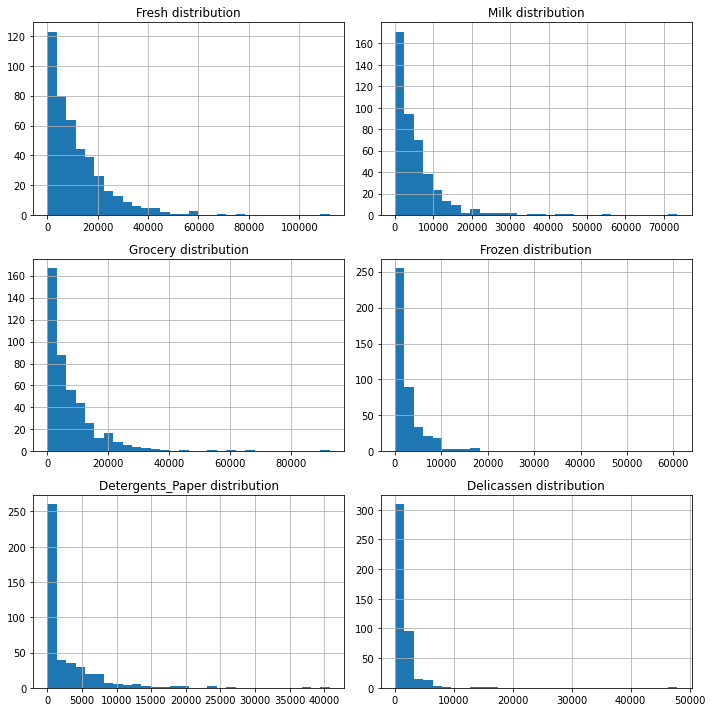

In [13]:
def draw_histograms(dataframe):
    
    fig = plt.figure(figsize=(10,10))

    for i, feature in enumerate(dataframe.columns):
        ax = fig.add_subplot(len(dataframe.columns)//2, 2, i+1)
        dataframe[feature].hist(bins=30, ax=ax)
        ax.set_title(feature+' distribution')
    
    fig.tight_layout()
    plt.ticklabel_format(useOffset=False, style='plain')
    plt.show()

draw_histograms(df)

The above figures illustrate significant variation in spending levels across different categories. The distributions exhibit heavy tails in all categories, indicating the presence of customers with significantly higher spending. These high-spending customers can disproportionately influence the overall distribution, overshadowing the spending patterns of the majority of retailers.

To address the issue of heavy-tailed distributions, we applied a nonlinear transformation to the data using the logarithmic function. We experimented with different values of theta from 1 to 200.
To verify the effect of this transformation, we recomputed the histograms for each category in the transformed space. 

Additionally, we used statistical tests, such as the Shapiro-Wilk test and the Jarque-Bera test, as tangible metrics to evaluate the normality of the distributions across different categories. 

Fresh


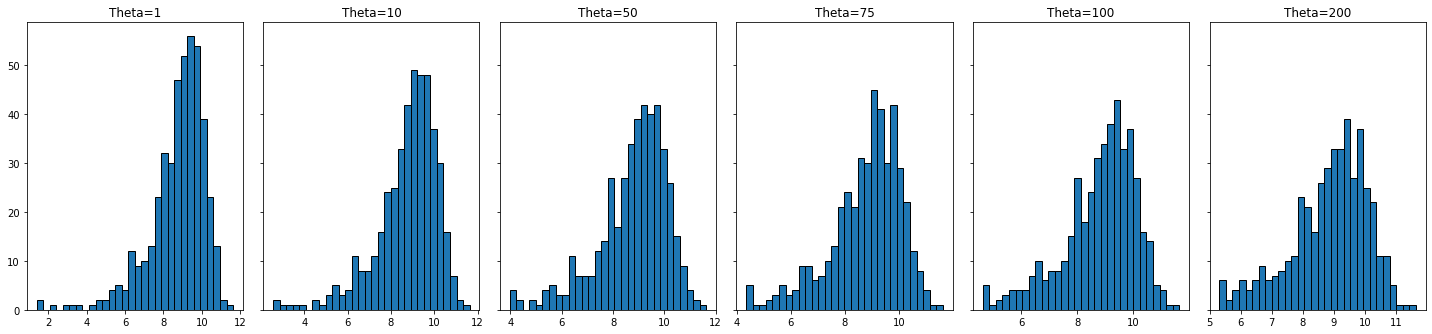

Jarque-Bera and Shapiro-Wilk Tests for Fresh

Jarque-Bera Test Results:
  Theta=1: Statistic=473.102, p-value=0.000
  Theta=10: Statistic=258.040, p-value=0.000
  Theta=50: Statistic=110.201, p-value=0.000
  Theta=75: Statistic=84.577, p-value=0.000
  Theta=100: Statistic=69.267, p-value=0.000
  Theta=200: Statistic=41.039, p-value=0.000

Shapiro-Wilk Test Results:
  Theta=1: Statistic=0.894, p-value=0.000
  Theta=10: Statistic=0.912, p-value=0.000
  Theta=50: Statistic=0.934, p-value=0.000
  Theta=75: Statistic=0.941, p-value=0.000
  Theta=100: Statistic=0.946, p-value=0.000
  Theta=200: Statistic=0.958, p-value=0.000


Milk


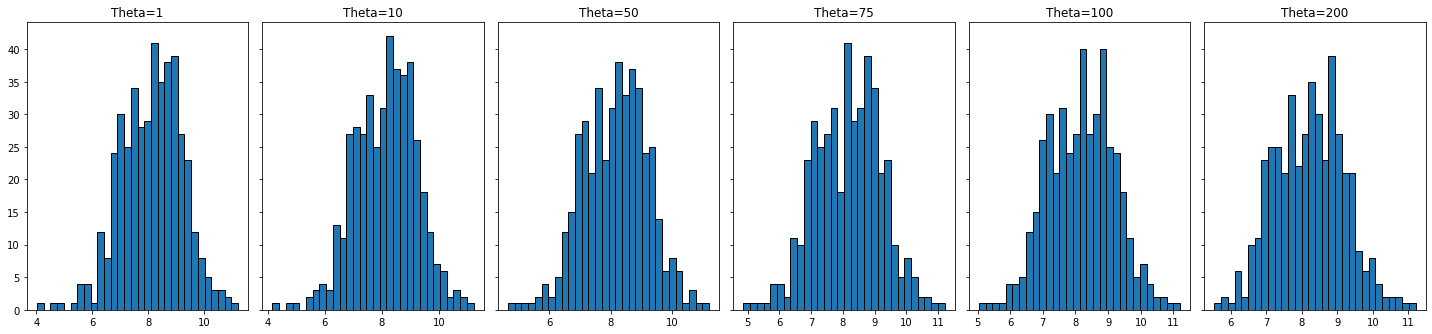

Jarque-Bera and Shapiro-Wilk Tests for Milk

Jarque-Bera Test Results:
  Theta=1: Statistic=4.353, p-value=0.113
  Theta=10: Statistic=3.212, p-value=0.201
  Theta=50: Statistic=1.057, p-value=0.589
  Theta=75: Statistic=0.725, p-value=0.696
  Theta=100: Statistic=0.700, p-value=0.705
  Theta=200: Statistic=1.742, p-value=0.419

Shapiro-Wilk Test Results:
  Theta=1: Statistic=0.994, p-value=0.090
  Theta=10: Statistic=0.995, p-value=0.142
  Theta=50: Statistic=0.996, p-value=0.386
  Theta=75: Statistic=0.997, p-value=0.473
  Theta=100: Statistic=0.997, p-value=0.498
  Theta=200: Statistic=0.996, p-value=0.279


Grocery


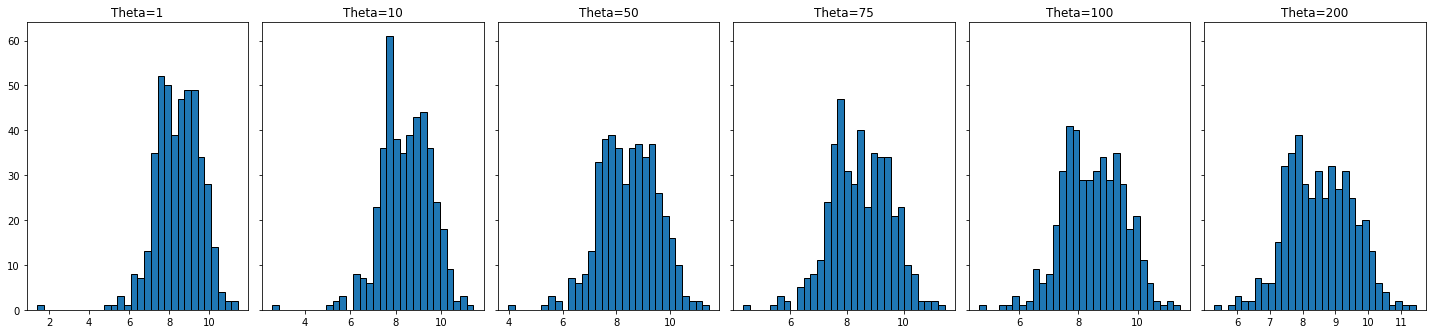

Jarque-Bera and Shapiro-Wilk Tests for Grocery

Jarque-Bera Test Results:
  Theta=1: Statistic=210.779, p-value=0.000
  Theta=10: Statistic=52.777, p-value=0.000
  Theta=50: Statistic=5.540, p-value=0.063
  Theta=75: Statistic=2.309, p-value=0.315
  Theta=100: Statistic=1.170, p-value=0.557
  Theta=200: Statistic=1.287, p-value=0.526

Shapiro-Wilk Test Results:
  Theta=1: Statistic=0.968, p-value=0.000
  Theta=10: Statistic=0.981, p-value=0.000
  Theta=50: Statistic=0.990, p-value=0.006
  Theta=75: Statistic=0.992, p-value=0.021
  Theta=100: Statistic=0.993, p-value=0.041
  Theta=200: Statistic=0.994, p-value=0.077


Frozen


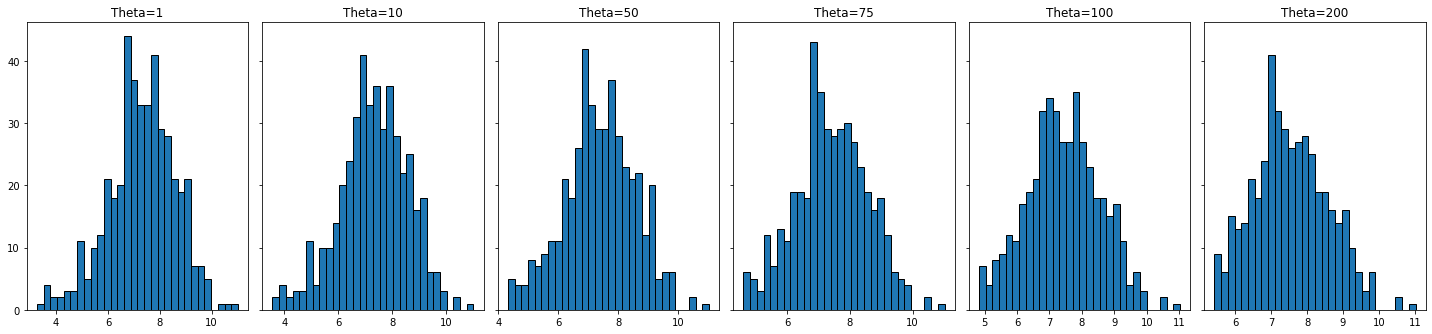

Jarque-Bera and Shapiro-Wilk Tests for Frozen

Jarque-Bera Test Results:
  Theta=1: Statistic=10.230, p-value=0.006
  Theta=10: Statistic=6.311, p-value=0.043
  Theta=50: Statistic=1.134, p-value=0.567
  Theta=75: Statistic=0.958, p-value=0.620
  Theta=100: Statistic=1.482, p-value=0.477
  Theta=200: Statistic=5.829, p-value=0.054

Shapiro-Wilk Test Results:
  Theta=1: Statistic=0.990, p-value=0.005
  Theta=10: Statistic=0.992, p-value=0.025
  Theta=50: Statistic=0.996, p-value=0.347
  Theta=75: Statistic=0.996, p-value=0.392
  Theta=100: Statistic=0.996, p-value=0.283
  Theta=200: Statistic=0.991, p-value=0.008


Detergents_Paper


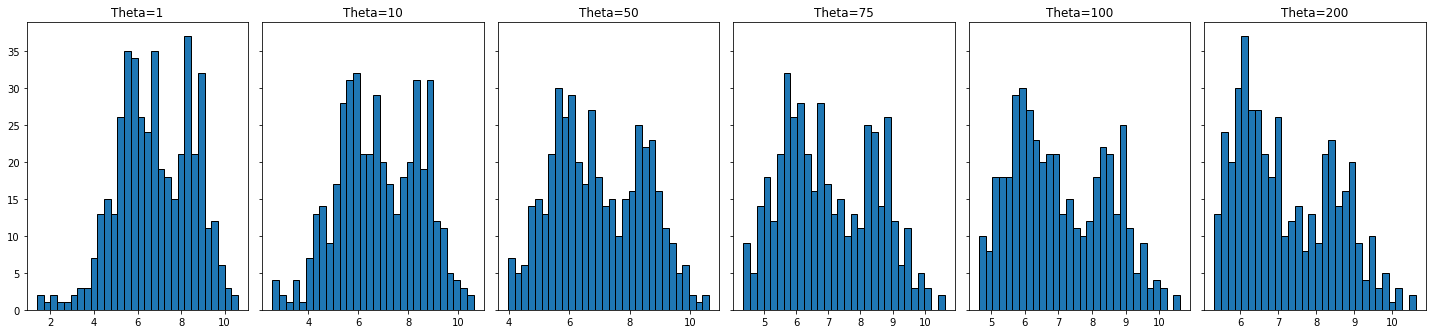

Jarque-Bera and Shapiro-Wilk Tests for Detergents_Paper

Jarque-Bera Test Results:
  Theta=1: Statistic=5.832, p-value=0.054
  Theta=10: Statistic=9.297, p-value=0.010
  Theta=50: Statistic=18.914, p-value=0.000
  Theta=75: Statistic=21.977, p-value=0.000
  Theta=100: Statistic=24.244, p-value=0.000
  Theta=200: Statistic=30.163, p-value=0.000

Shapiro-Wilk Test Results:
  Theta=1: Statistic=0.982, p-value=0.000
  Theta=10: Statistic=0.983, p-value=0.000
  Theta=50: Statistic=0.972, p-value=0.000
  Theta=75: Statistic=0.966, p-value=0.000
  Theta=100: Statistic=0.960, p-value=0.000
  Theta=200: Statistic=0.942, p-value=0.000


Delicassen


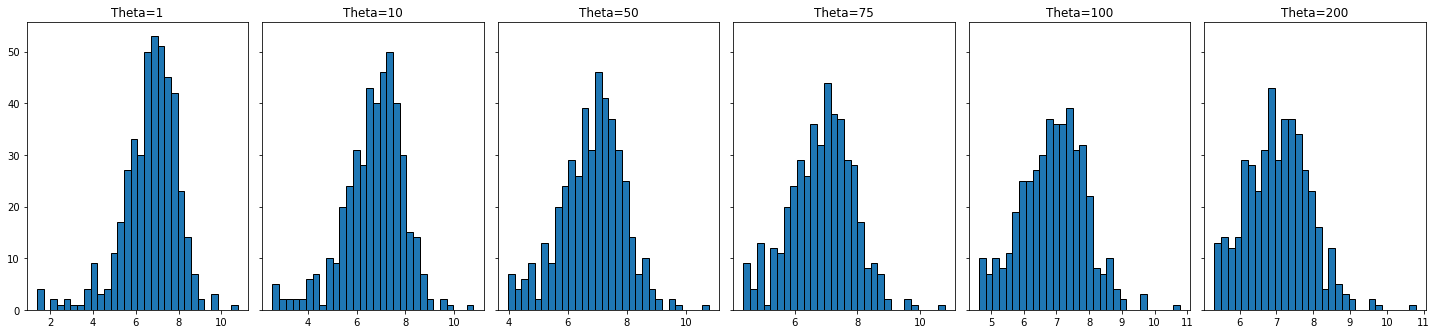

Jarque-Bera and Shapiro-Wilk Tests for Delicassen

Jarque-Bera Test Results:
  Theta=1: Statistic=220.874, p-value=0.000
  Theta=10: Statistic=73.561, p-value=0.000
  Theta=50: Statistic=8.135, p-value=0.017
  Theta=75: Statistic=2.564, p-value=0.278
  Theta=100: Statistic=1.257, p-value=0.533
  Theta=200: Statistic=10.018, p-value=0.007

Shapiro-Wilk Test Results:
  Theta=1: Statistic=0.936, p-value=0.000
  Theta=10: Statistic=0.962, p-value=0.000
  Theta=50: Statistic=0.987, p-value=0.000
  Theta=75: Statistic=0.990, p-value=0.006
  Theta=100: Statistic=0.992, p-value=0.014
  Theta=200: Statistic=0.988, p-value=0.001




In [14]:
def draw_histograms_per_col(df, column, thetas):
    fig, axes = plt.subplots(1, len(thetas), figsize=(20, 5), sharey=True)
    for ax, theta in zip(axes, thetas):
        data = np.log(df[column] + theta)
        ax.hist(data, bins=30, edgecolor='black')
        ax.set_title(f'Theta={theta}')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


thetas = [1, 10, 50, 75, 100, 200]

for column in df.columns:
    print(column)
    draw_histograms_per_col(df, column, thetas)
    print(f"Jarque-Bera and Shapiro-Wilk Tests for {column}\n")
    
    jb_results = []
    shapiro_results = []

    for theta in thetas:
        df_t1 = np.log(df[column] + theta)
        
        # Jarque-Bera Test
        jb_stat, jb_p_value = jarque_bera(df_t1)
        jb_results.append((theta, jb_stat, jb_p_value))
        
        # Shapiro-Wilk Test
        shapiro_stat, shapiro_p_value = shapiro(df_t1)
        shapiro_results.append((theta, shapiro_stat, shapiro_p_value))
    
    print("Jarque-Bera Test Results:")
    for theta, jb_stat, jb_p_value in jb_results:
        print(f"  Theta={theta}: Statistic={jb_stat:.3f}, p-value={jb_p_value:.3f}")
    
    print("\nShapiro-Wilk Test Results:")
    for theta, shapiro_stat, shapiro_p_value in shapiro_results:
        print(f"  Theta={theta}: Statistic={shapiro_stat:.3f}, p-value={shapiro_p_value:.3f}")

    print("\n" + "="*50 + "\n")


By applying this log transformation and experimenting with different 
θ values, we aimed to reduce the impact of extreme values and make the distributions more symmetric and closer to a Gaussian distribution. This approach, combined with the use of statistical tests like Shapiro-Wilk and Jarque-Bera, provided us with both visual and quantitative metrics to evaluate the normality of the distributions in each category. With these metrics and histogram analyses, we have decided that  θ=100 is the best value, as it results in a more Gaussian-like distribution for most categories.

In [15]:
#selected 100 as a result of the comparison of distribution to Gaussian one 
theta=100
df_transformed=df.apply(lambda x: np.log(x+theta))
df_transformed.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,9.454776,9.185638,8.943898,5.749393,7.928046,7.271009
1,8.875846,9.201300,9.176577,7.529406,8.129470,7.536897
2,8.772300,9.094705,8.959826,7.826044,8.193124,8.980172
3,9.500395,7.167038,8.371242,8.780173,6.408529,7.543273
4,10.030781,8.614320,8.895356,8.297793,7.537430,8.572628


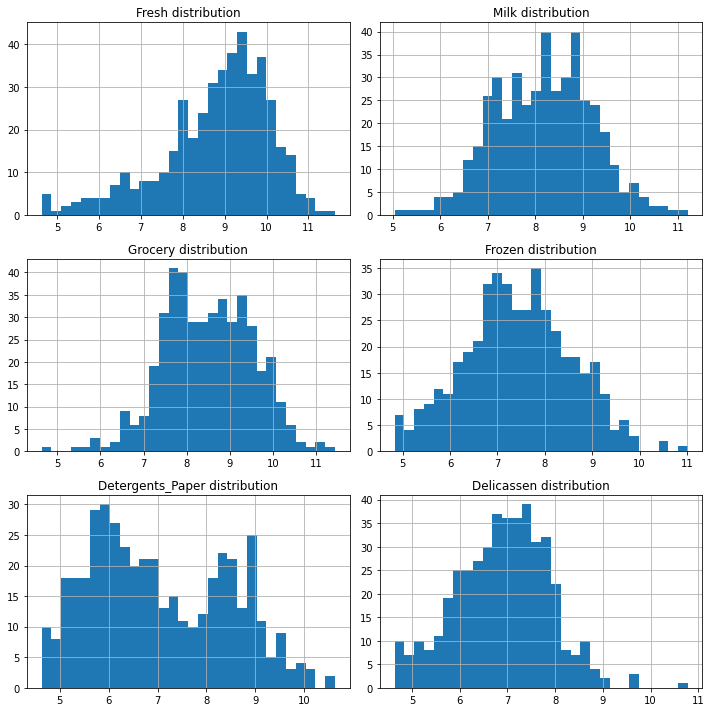

In [16]:
# Plot histograms for each category after transformation
draw_histograms(df_transformed)

To visually detect deviations from a normal distribution for each spending category, we also plotted QQ-plots for each transformed category. If the data points closely follow the straight line, it suggests normality. Deviations from this line indicate departures from normality.

After applying the log transformation with θ=100, the QQ-plots for most spending categories showed data points aligning more closely with the standard line. This indicates a more Gaussian-like distribution, confirming that 
θ=100 is optimal for transforming the data.

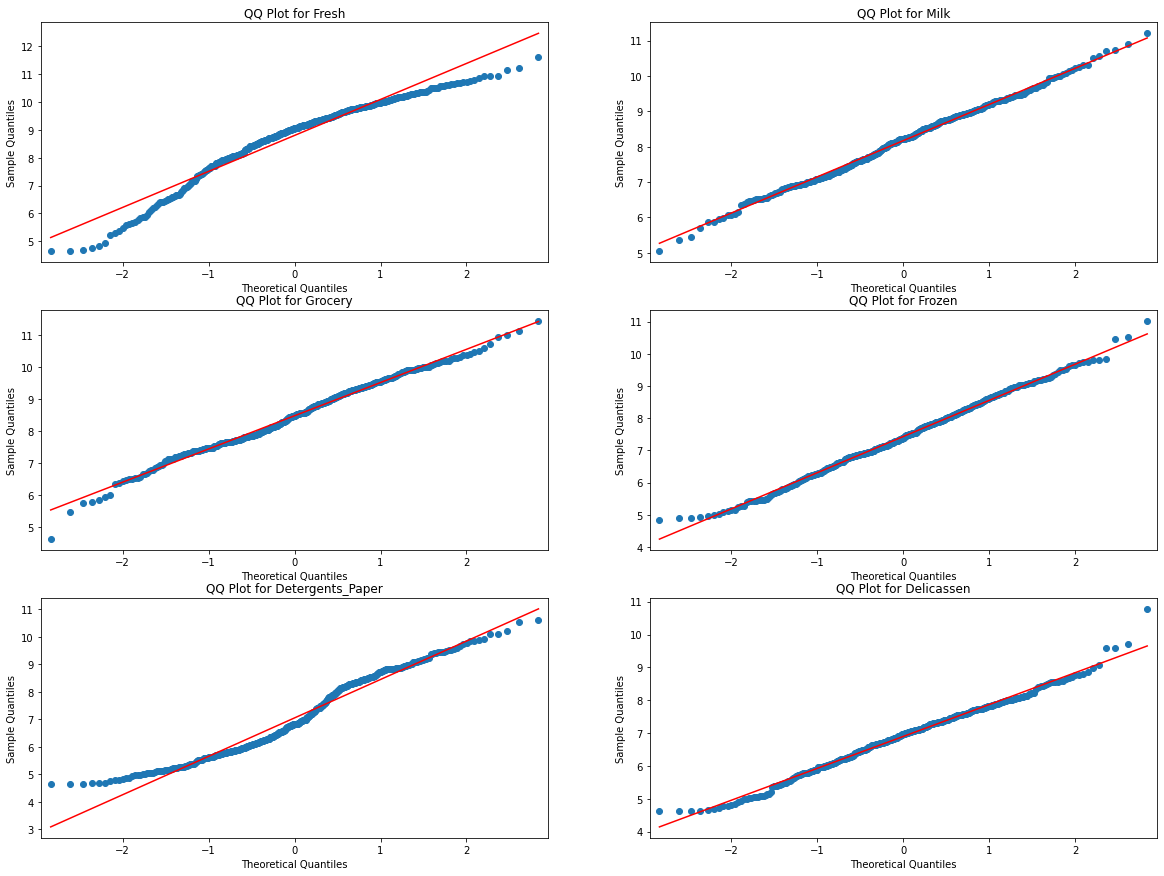

In [17]:
#plotting q-q plot for each spending category to visually detect deviations from normal dist 
fig, axes = plt.subplots(nrows=3, ncols=df_transformed.shape[1]//3, figsize=(20, 15))

for col, ax in zip(df_transformed.columns, axes.flatten()):
    qqplot(df_transformed[col], line='s', ax=ax)  # 's' means standard line fit
    ax.title.set_text(f'QQ Plot for {col}')

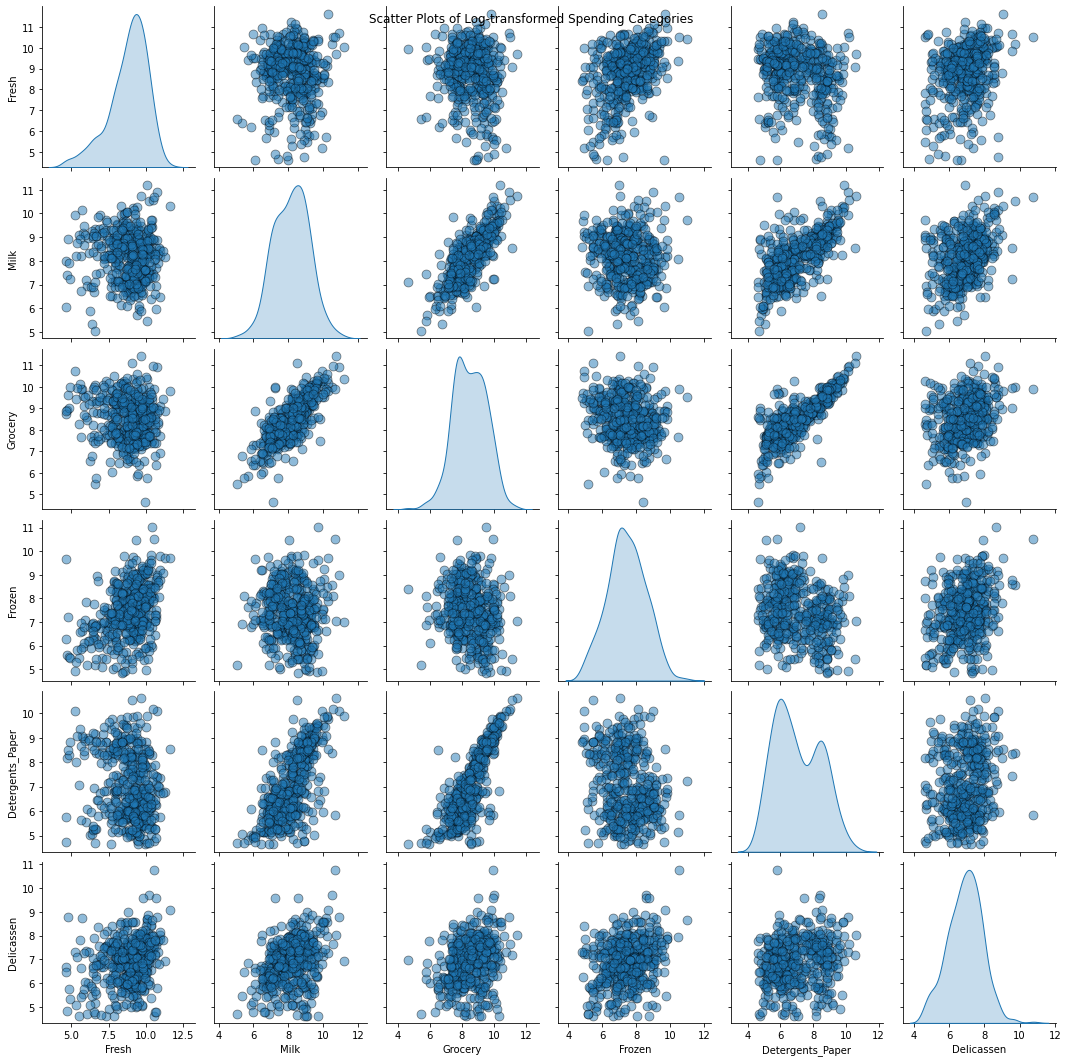

In [18]:
# Plot scatter plots for each pair of categories
sns.pairplot(df_transformed, diag_kind='kde', plot_kws={'alpha': 0.5, 's': 80, 'edgecolor': 'k'})
plt.suptitle('Scatter Plots of Log-transformed Spending Categories')
plt.show()

### 2. Robust Detection of Anomalies

For detecting outliers, we utilized soft minimum approach, which offers a more robust measure of outlierness by considering multiple neighbors instead of just the closest one.  

Moreover, the log-sum-exp trick is used to compute the soft minimum, which improves numerical stability and prevents underflow and overflow issues  by transforming the sum of exponentials into a logarithm of the sum of exponentials.<br>
This transformation is particularly important when dealing with large datasets or large values of γ, where direct computation of the exponentials could result in numerical inaccuracies.

In [19]:
#log-sum-exp trick is used to increase accuracy and avoid underflow and overflow problems
def softmin(distances, gamma):
    return (-1/gamma)*scipy.special.logsumexp(-gamma*distances)+(1/gamma)*np.log(distances.shape[0])

In [20]:
# Precomputing the distance matrix for efficiency of computation in bootstrapping
distances_mtx = np.square(distance_matrix(df_transformed, df_transformed))

def compute_outlierness_score(distances_mtx, gamma):
    scores = []
    for i in range(distances_mtx.shape[0]):
        distances = np.delete(distances_mtx[i], i)  # Remove the distance from the point to itself, and ensuring N-1
        score = softmin(distances, gamma)
        scores.append(score)
    return np.array(scores)

To verify the reproducibility gain from using the softmin approach for anomaly detection, we applied the bootstrapping method. This bootstrap method involves simulating multiple variants of the dataset by randomly sampling instances (with repetition) from the original dataset. After resampling each time, the specific instance is added as final one to ensure its existence in new samples.

In [21]:
# Bootstrap method for computing scores for a specific instance
def compute_bootstrap_score(idx, distances_mtx, gamma, n_bootstraps, n_instances):
    scores = []
    for _ in range(n_bootstraps):
        sample_indices = random.choices(range(n_instances), k=n_instances)
        sample_indices[-1] = idx  # ensuring specific instance is included
        sample_distances = distances_mtx[sample_indices][:, sample_indices]
        score = compute_outlierness_score(sample_distances, gamma)
        scores.append(score[-1])  # score for specific instance  last
    return idx, gamma, np.array(scores)

To efficiently handle the extensive computational load, we utilized parallel processing with joblib. This approach significantly accelerates the bootstrap calculations within loops by distributing the workload across multiple CPU cores. Each core simultaneously processes different gamma values and instances, reducing the overall computation time compared to sequential processing.

In [22]:
#start_time = time.time()
n_instances = distances_mtx.shape[0]


gamma_values = np.array([ 0.01, 0.1, 1, 2, 10, 100]) # multiple gamma values to test
n_bootstraps = 100  # Number of bootstrap samples

# Parallel computation for each gamma value and instance for enhancing the computation via loops
results = Parallel(n_jobs=-1)(
    delayed(compute_bootstrap_score)(idx, distances_mtx, gamma, n_bootstraps, n_instances) 
    for gamma in gamma_values 
    for idx in range(n_instances)
)

all_bootstrap_scores = {gamma: np.zeros((n_instances, n_bootstraps)) for gamma in gamma_values}
for idx, gamma, scores in results:
    all_bootstrap_scores[gamma][idx] = scores

#print("--- Total time for computation ---", time.time() - start_time)

Then,as the anomaly scores were computed for each variant, each instance's anomaly was characterized by its mean and spread.

In [23]:
# Compute mean and std dev anomaly scores for each instance and gamma
mean_scores = {gamma: np.mean(scores, axis=1) for gamma, scores in all_bootstrap_scores.items()}
std_scores = {gamma: np.std(scores, axis=1) for gamma, scores in all_bootstrap_scores.items()}

### 2.2 Selecting a suitable parameter γ

For deciding on which value of the gamma is better to achieve seperability between nonanomolous and anomolous instances.

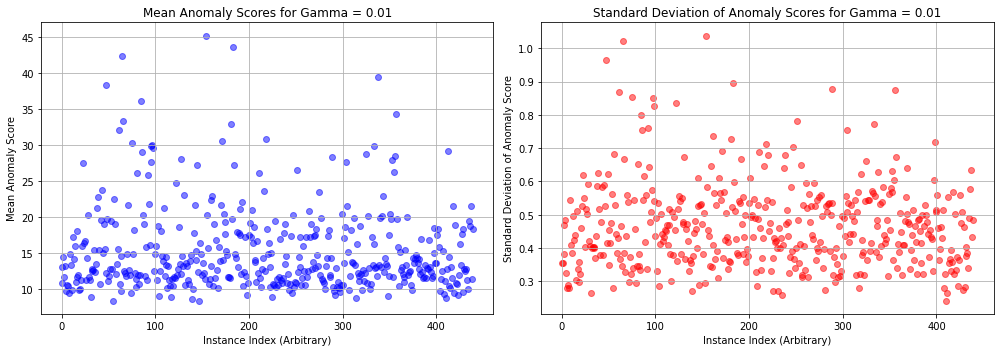

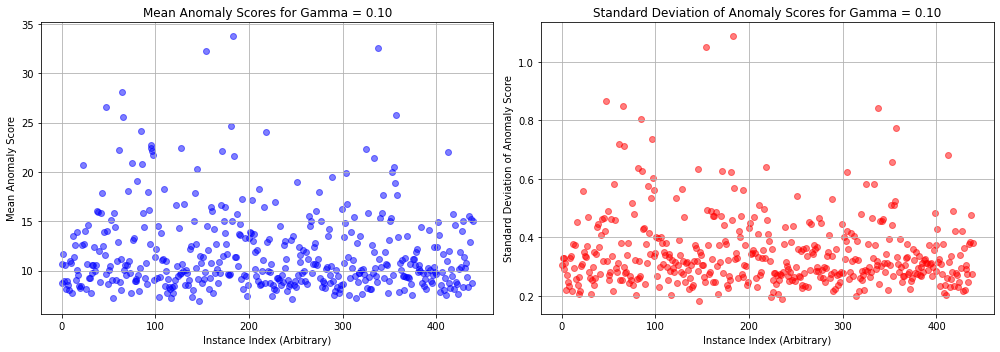

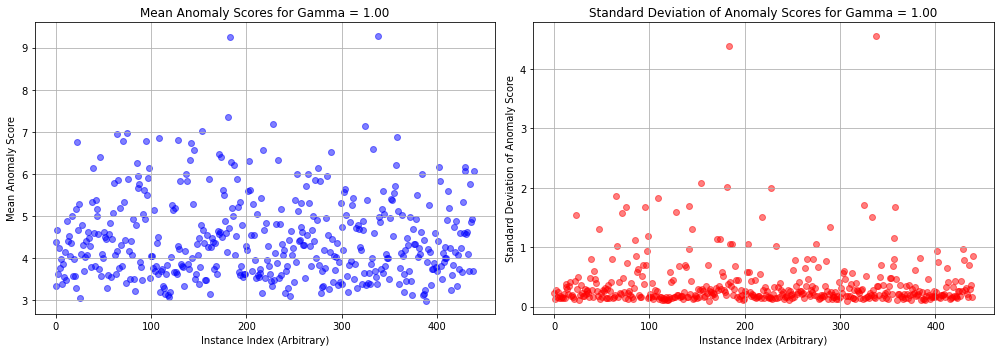

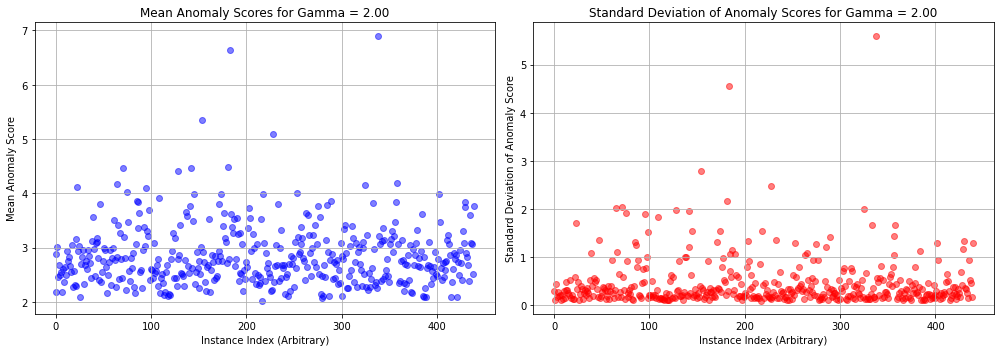

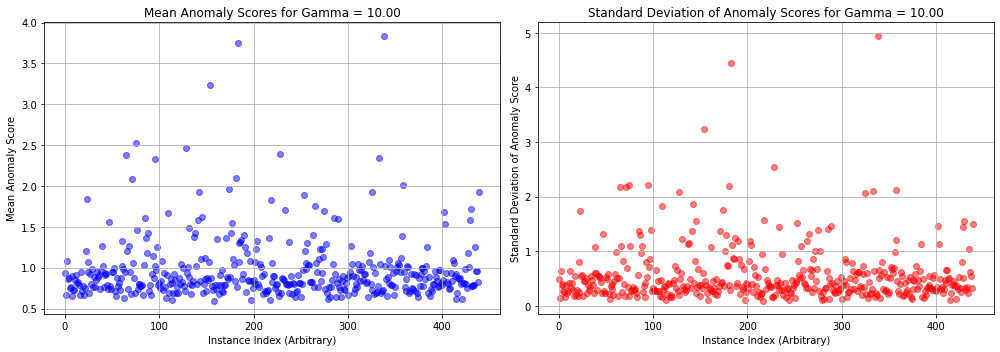

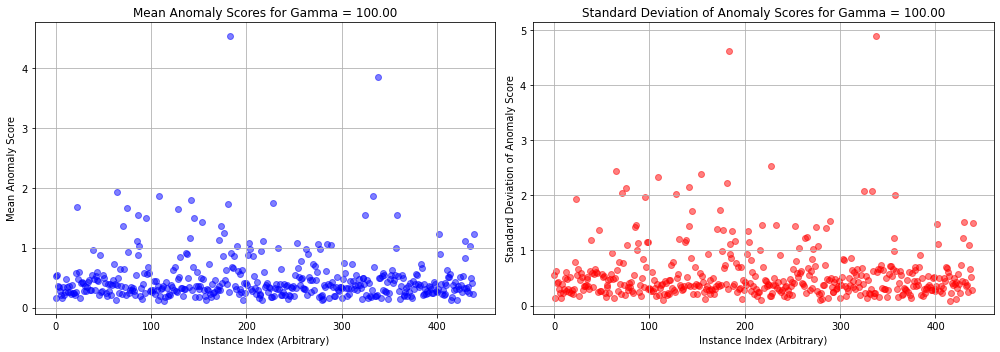

In [24]:
# Plotting mean and standard deviation of anomaly scores for each gamma
for gamma in gamma_values:
    mean_score = mean_scores[gamma]
    std_dev_score = std_scores[gamma]
    
    plt.figure(figsize=(14, 5))
    
    # Plotting mean scores
    plt.subplot(1, 2, 1)
    plt.scatter(range(len(mean_score)), mean_score, c='b', alpha=0.5)
    plt.title(f'Mean Anomaly Scores for Gamma = {gamma:.2f}')
    plt.xlabel('Instance Index (Arbitrary)')
    plt.ylabel('Mean Anomaly Score')
    plt.grid(True)
    
    # Plotting standard deviation of scores
    plt.subplot(1, 2, 2)
    plt.scatter(range(len(std_dev_score)), std_dev_score, c='r', alpha=0.5)
    plt.title(f'Standard Deviation of Anomaly Scores for Gamma = {gamma:.2f}')
    plt.xlabel('Instance Index (Arbitrary)')
    plt.ylabel('Standard Deviation of Anomaly Score')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [25]:
def plot_gaussians(mean, std):
    fig = plt.figure(figsize=(12,8))
    for i in range(len(mean)):
        mu = mean[i]
        sigma = std[i]
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        plt.plot(x, norm.pdf(x, mu, sigma), alpha=0.3)
    plt.title(f'Gamma={gamma}')
    plt.show()

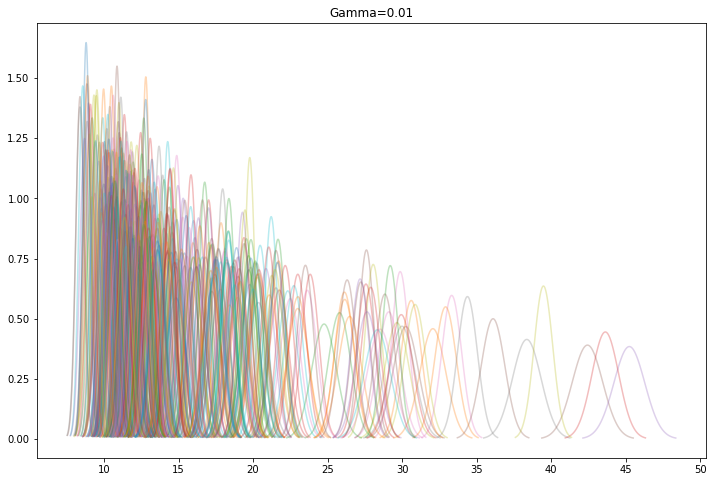

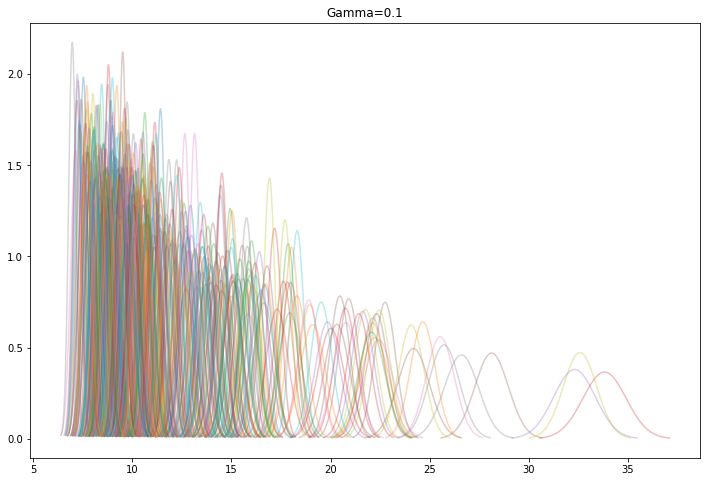

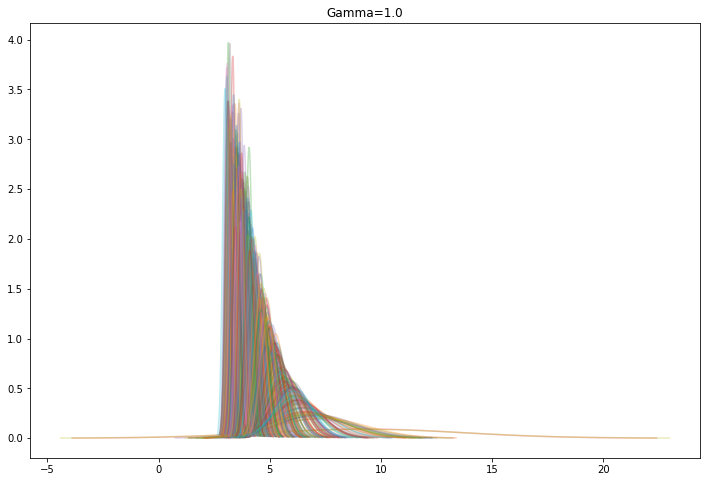

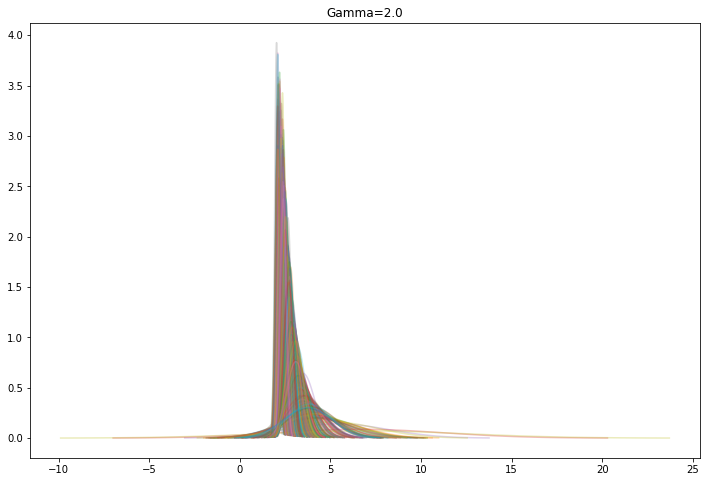

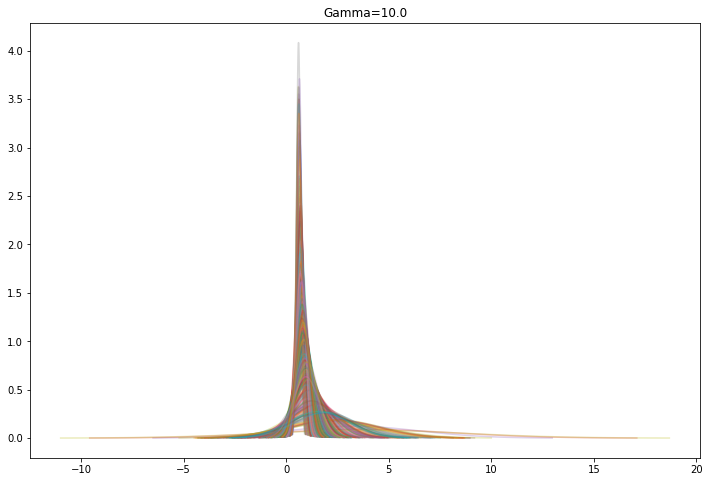

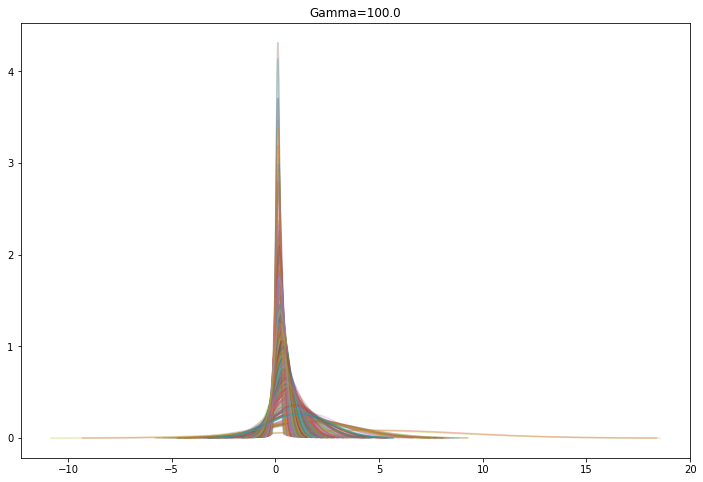

In [26]:
for gamma in gamma_values:
    mean_score = mean_scores[gamma]
    std_dev_score = std_scores[gamma]
    plot_gaussians(mean_score, std_dev_score)

From the scatter plots of mean and standard deviation scores, along with the histograms for each instance, we observe that when gamma is in the range of 1-2, there is better visual separability between the mean scores of anomalous and non-anomalous instances, while the variation in standard deviation remains reasonably low. To determine the exact optimal gamma value, we need to formalize this observation using an appropriate evaluation metric.

In [27]:
# Function to compute the Dunn index
def dunn_index(X, labels):
    distances = pdist(X)
    distances_matrix = squareform(distances)
    unique_clusters = np.unique(labels)
    min_intercluster_distance = np.min([np.min(distances_matrix[labels == k, :][:, labels != k]) for k in unique_clusters])
    max_intracluster_distance = np.max([np.max(distances_matrix[labels == k, :][:, labels == k]) for k in unique_clusters])
    return min_intercluster_distance / max_intracluster_distance

For that, we selected the top 50 and bottom 50 instances based on their anomaly scores. We then applied clustering to these instances using their mean and standard deviation values. To assess which value of gamma ensures better separability, we utilized clustering evaluation metrics such as the Calinski-Harabasz Index, Silhouette Score, and Dunn Index.

**Calinski-Harabasz Index**: This index, also known as the Variance Ratio Criterion, evaluates the ratio of the sum of between-cluster dispersion to within-cluster dispersion. Higher values indicate well-defined clusters. It is particularly useful for identifying clusters that are dense and well-separated.

**Silhouette Score**: The silhouette score measures how similar an instance is to its own cluster compared to other clusters. This score ranges from -1 to 1, where higher values indicate that instances are well matched to their own cluster and poorly matched to neighboring clusters. It provides insight into both cluster cohesion and separation.

**Dunn Index**: This index focuses on identifying clusters that are compact and well-separated. It is calculated as the ratio of the minimum inter-cluster distance to the maximum intra-cluster distance. Higher values indicate better clustering quality, emphasizing distinct and non-overlapping clusters.

By using these metrics, we aim to determine the gamma value that results in the most distinct separation between anomalous and non-anomalous instances.

In [28]:
# Evaluate clustering quality using CH, Dunn, and Silhouette indices
ch_indices = []
dunn_indices = []
silhouette_scores = []

for gamma in gamma_values:
    mean_score = mean_scores[gamma]
    std_score = std_scores[gamma]
    
    # Sort indices based on mean anomaly scores, and pick top and bottom 50
    sorted_indices = np.argsort(mean_score)
    top_indices = sorted_indices[-50:]  # Last 50
    bottom_indices = sorted_indices[:50]  # First 50
    
    # Extract the mean and std dev scores for top and bottom
    selected_mean_scores = np.concatenate((mean_score[top_indices], mean_score[bottom_indices]))
    selected_std_scores = np.concatenate((std_score[top_indices], std_score[bottom_indices]))
    
    # Form the data for clustering
    data_for_clustering = np.column_stack((selected_mean_scores, selected_std_scores))
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=2, random_state=42).fit(data_for_clustering)
    labels = kmeans.labels_
    
    # Calculate Dunn Index
    dunn_idx = dunn_index(data_for_clustering, labels)
    dunn_indices.append(dunn_idx)
    
    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(data_for_clustering, labels)
    silhouette_scores.append(silhouette_avg)

    # Calculate Calinski-Harabasz Index
    ch_score = calinski_harabasz_score(data_for_clustering, labels)
    ch_indices.append(ch_score)
    
    print(f'γ: {gamma}, CH Index: {ch_score:.3f}, Dunn Index: {dunn_idx:.3f}, Silhouette Score: {silhouette_avg:.3f}')

γ: 0.01, CH Index: 506.766, Dunn Index: 0.470, Silhouette Score: 0.809
γ: 0.1, CH Index: 495.017, Dunn Index: 0.470, Silhouette Score: 0.815
γ: 1.0, CH Index: 529.813, Dunn Index: 0.469, Silhouette Score: 0.845
γ: 2.0, CH Index: 239.204, Dunn Index: 0.257, Silhouette Score: 0.795
γ: 10.0, CH Index: 196.666, Dunn Index: 0.203, Silhouette Score: 0.740
γ: 100.0, CH Index: 176.972, Dunn Index: 0.181, Silhouette Score: 0.742


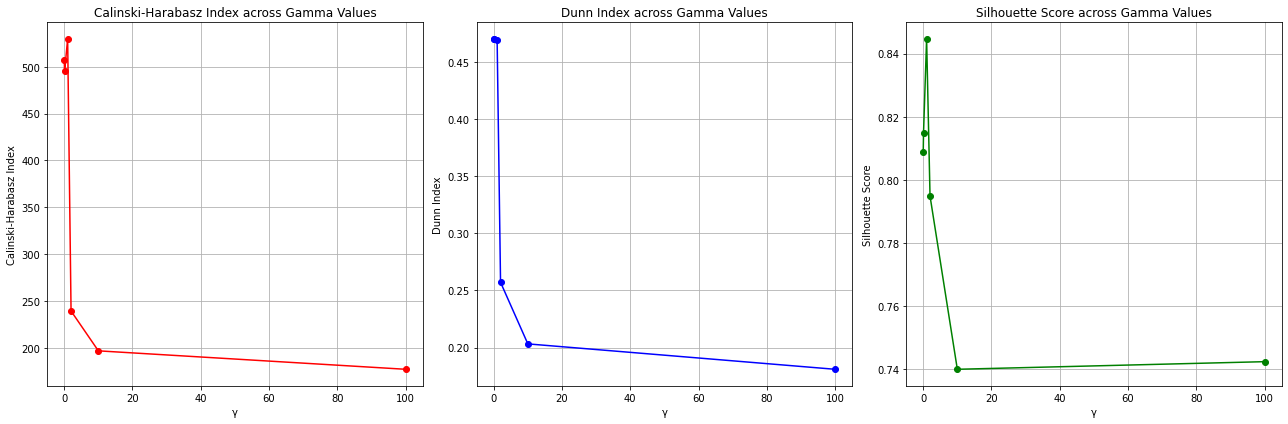

In [29]:
# Plotting the metrics
metrics = [ch_indices, dunn_indices, silhouette_scores]
titles = ['Calinski-Harabasz Index', 'Dunn Index', 'Silhouette Score']
colors = ['r', 'b', 'g']
y_labels = ['Calinski-Harabasz Index', 'Dunn Index', 'Silhouette Score']

plt.figure(figsize=(18, 6))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    plt.plot(gamma_values, metric, marker='o', color=colors[i])
    plt.title(f'{titles[i]} across Gamma Values')
    plt.xlabel('γ')
    plt.ylabel(y_labels[i])
    plt.grid(True)

plt.tight_layout()
plt.show()


After visually analyzing metric results across multitude of gamma candidates, we look for a balance where  metrics are reasonably high. We see γ=1  yields the highest CH Index and Silhouette Score, indicating the best overall clustering quality with the most distinct and well-defined clusters. The Dunn Index is also high, showing good separation.
Now as we selected γ=1,we recompute a single anomaly model with this parameter γ on the whole data.

In [30]:
#recomputing final model
gamma = 1
anomaly_scores=compute_outlierness_score(distances_mtx, gamma)

In [31]:
anomaly_scores = pd.DataFrame(anomaly_scores, index=df_transformed.index, columns=['Outlier Score'])
anomalies = anomaly_scores.sort_values(by='Outlier Score', ascending=False)
anomalies.head(10)

,Outlier Score
183,13.751210
338,13.705643
154,10.466857
228,9.808164
181,9.587878
65,9.492981
95,9.177682
325,9.103668
75,8.967938
71,8.964518


Then, we scaled anomaly scores using MinMaxScaler. This scaling normalizes the scores to a range between 0 and 1, making them easier to interpret and compare. It also enhances the performance of further analysis and visualization by ensuring consistency.

In [32]:
df_copy = df_transformed.copy()
df_copy['Outlier Score'] = anomaly_scores['Outlier Score']

In [33]:
scaler = MinMaxScaler()
df_copy['Norm Outlier Score'] = scaler.fit_transform(df_copy[['Outlier Score']])

In [34]:
#top 10 outliers
df_copy[['Norm Outlier Score']].sort_values(by='Norm Outlier Score', ascending=False).head(10)

,Norm Outlier Score
183,1.000000
338,0.995751
154,0.693723
228,0.632297
181,0.611755
65,0.602905
95,0.573502
325,0.566600
75,0.553943
71,0.553624


In [35]:
#bottom 10 outliers
df_copy[['Norm Outlier Score']].sort_values(by='Norm Outlier Score', ascending=False).tail(10)

,Norm Outlier Score
387,0.014094
162,0.013616
374,0.013518
118,0.013369
385,0.012722
217,0.012584
246,0.010076
119,0.007469
26,0.005322
389,0.000000


To visually represent the results, we applied t-SNE and color-coded each data point according to its normalized outlier score. This plot helped in visualizing the clustering and separation of data points based on their outlierness.

In [36]:
#T-SNE
tsne = TSNE(n_components=2,perplexity=100,  random_state=42)  
tsne_results = tsne.fit_transform(df_copy.drop(['Outlier Score', 'Norm Outlier Score'], axis=1))

df_copy['tsne-2d-1'] = tsne_results[:, 0]
df_copy['tsne-2d-2'] = tsne_results[:, 1]


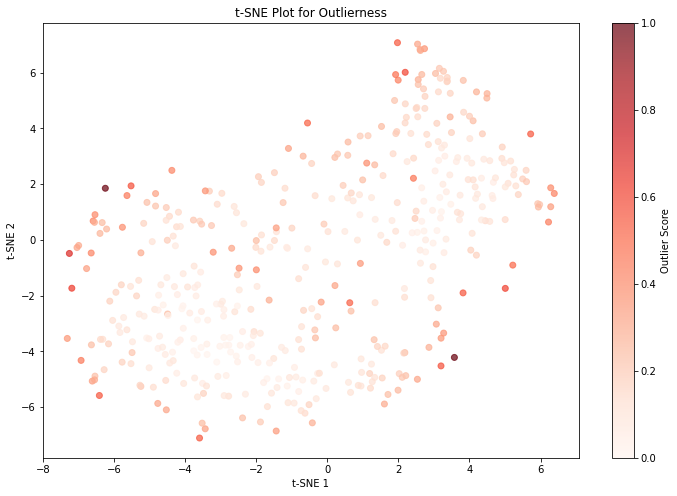

In [37]:
plt.figure(figsize=(12,8))
scatter = plt.scatter(df_copy['tsne-2d-1'], df_copy['tsne-2d-2'], 
                      c=df_copy['Norm Outlier Score'],cmap="Reds", alpha=0.7)

plt.colorbar(scatter, label='Outlier Score')
plt.title('t-SNE Plot for Outlierness')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

### 3.1 Analysis of the relation between anomalies and metadata 

In order to analyze the relation between metadata and anomalier, we need to plot the distribution of anomaly scores for different subsets of data based on channel and region. For that, we will use box plots and violin plots.

In [38]:
df_c['Outlier Score']=df_copy['Norm Outlier Score']

In [39]:
df_c

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Outlier Score
0,Retail,Other Region,12669,9656,7561,214,2674,1338,0.143145
1,Retail,Other Region,7057,9810,9568,1762,3293,1776,0.033729
2,Retail,Other Region,6353,8808,7684,2405,3516,7844,0.181014
3,Horeca,Other Region,13265,1196,4221,6404,507,1788,0.064139
4,Retail,Other Region,22615,5410,7198,3915,1777,5185,0.126219
...,...,...,...,...,...,...,...,...,...
435,Horeca,Other Region,29703,12051,16027,13135,182,2204,0.317930
436,Horeca,Other Region,39228,1431,764,4510,93,2346,0.197567
437,Retail,Other Region,14531,15488,30243,437,14841,1867,0.209725
438,Horeca,Other Region,10290,1981,2232,1038,168,2125,0.070081


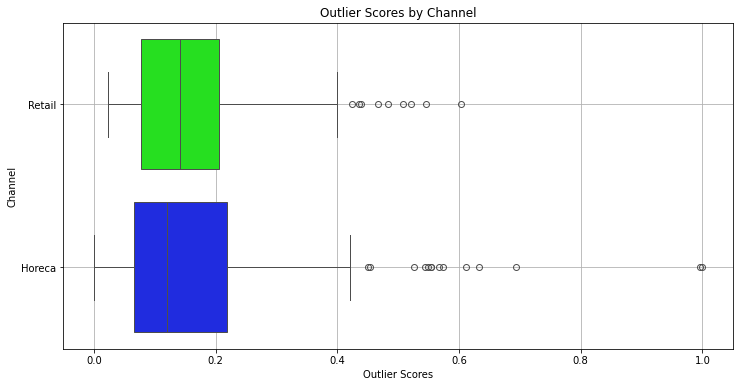

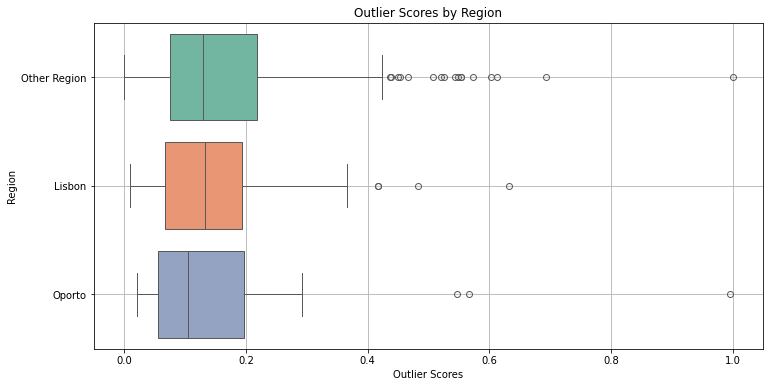

In [40]:
# Plotting boxplots for Channel variable
channel_colors = sns.color_palette('hsv', n_colors=len(df_c['Channel'].unique()))
plt.figure(figsize=(12, 6))
sns.boxplot(x='Outlier Score', y='Channel', data=df_c, orient='h', palette=channel_colors)
plt.title('Outlier Scores by Channel')
plt.xlabel('Outlier Scores')
plt.ylabel('Channel')
plt.grid(True)
plt.show()

# Plotting boxplots for Region variable
region_colors = sns.color_palette('Set2', n_colors=len(df_c['Region'].unique()))
plt.figure(figsize=(12, 6))
sns.boxplot(x='Outlier Score', y='Region', data=df_c, orient='h', palette=region_colors)
plt.title('Outlier Scores by Region')
plt.xlabel('Outlier Scores')
plt.ylabel('Region')
plt.grid(True)
plt.show()

In [41]:
#we see median from boxplot, just for numerical representation
df_c.groupby('Channel')['Outlier Score'].median().round(3)

Channel
Horeca    0.120
Retail    0.141
Name: Outlier Score, dtype: float64

In [42]:
df_c[df_c['Outlier Score'] > 0.4].groupby('Channel').size()

Channel
Horeca    19
Retail     9
dtype: int64

In [43]:
df_c.groupby('Region')['Outlier Score'].median().round(3)
#Lisbon and Other Region has almost same median outlier score

Region
Lisbon          0.133
Oporto          0.105
Other Region    0.129
Name: Outlier Score, dtype: float64

In [44]:
df_c[df_c['Outlier Score'] > 0.4].groupby('Region').size()

Region
Lisbon           4
Oporto           3
Other Region    21
dtype: int64

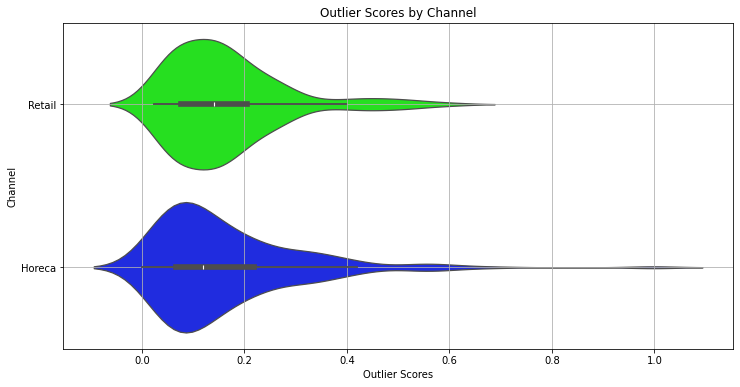

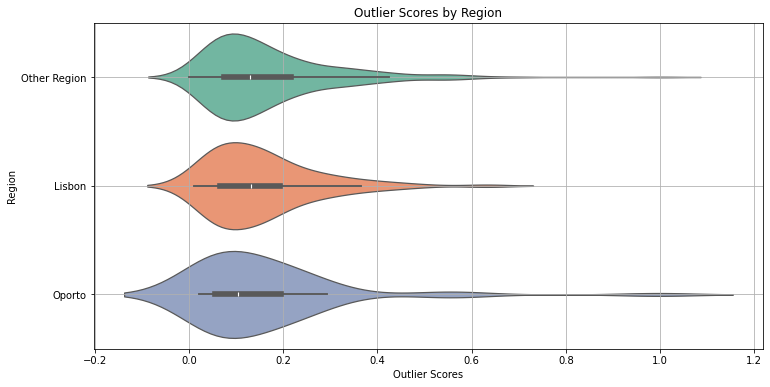

In [45]:
# Plotting violin plots for the 'Channel' variable
channel_colors = sns.color_palette('hsv', n_colors=len(df_c['Channel'].unique()))
plt.figure(figsize=(12, 6))
sns.violinplot(x='Outlier Score', y='Channel', data=df_c, orient='h', palette=channel_colors)
plt.title('Outlier Scores by Channel')
plt.xlabel('Outlier Scores')
plt.ylabel('Channel')
plt.grid(True)
plt.show()

# Plotting violin plots for the 'Region' variable
region_colors = sns.color_palette('Set2', n_colors=len(df_c['Region'].unique()))
plt.figure(figsize=(12, 6))
sns.violinplot(x='Outlier Score', y='Region', data=df_c, orient='h', palette=region_colors)
plt.title('Outlier Scores by Region')
plt.xlabel('Outlier Scores')
plt.ylabel('Region')
plt.grid(True)
plt.show()

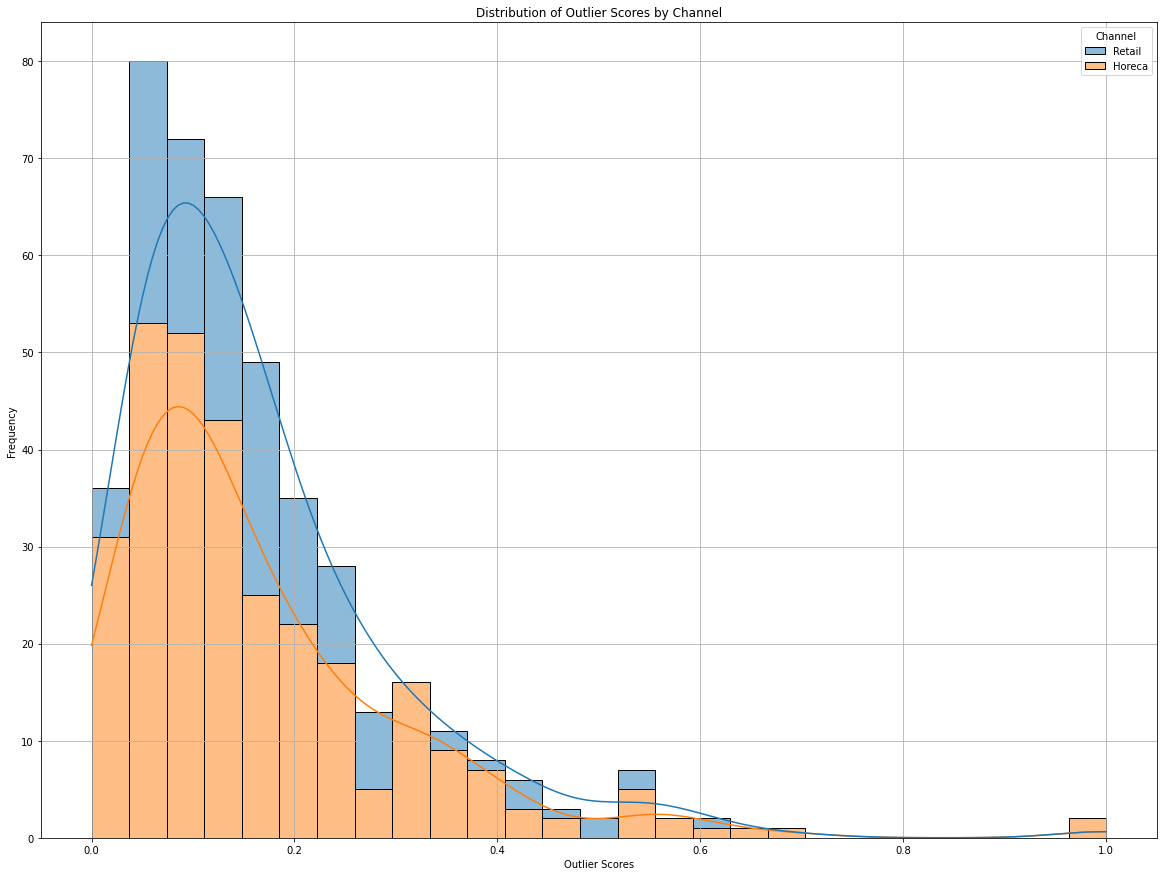

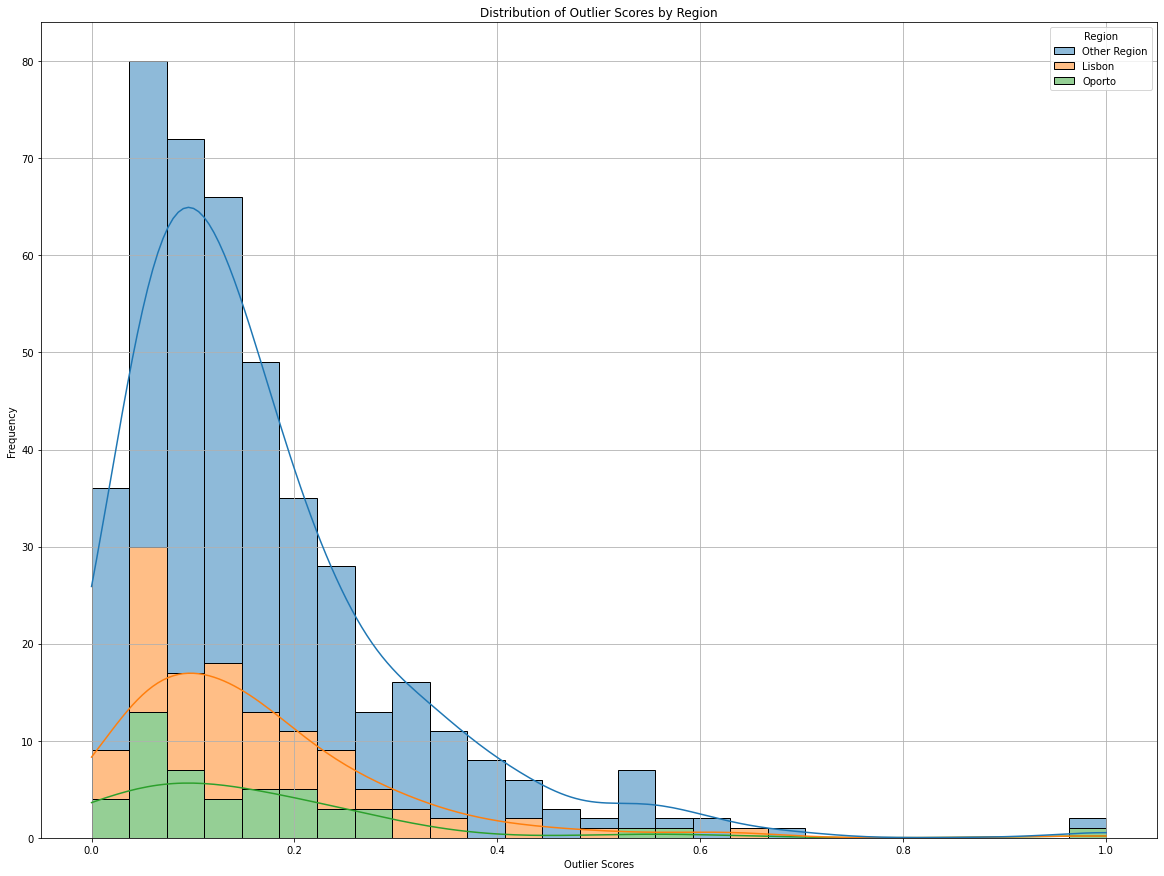

In [46]:
# Histograms for the 'Channel' variable
plt.figure(figsize=(20, 15))
sns.histplot(data=df_c, x='Outlier Score', hue='Channel', multiple='stack', kde=True)
plt.title('Distribution of Outlier Scores by Channel')
plt.xlabel('Outlier Scores')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Histograms for the 'Region' variable
plt.figure(figsize=(20, 15))
sns.histplot(data=df_c, x='Outlier Score', hue='Region', multiple='stack', kde=True)
plt.title('Distribution of Outlier Scores by Region')
plt.xlabel('Outlier Scores')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Based on the figures **by Channel**, we observed the following:

**Retail Channel:**

The scores for retail channels are generally lower, indicating fewer anomalies.<br>
There are 9 instances with anomaly scores higher than 0.4.<br>
The median anomaly score for the retail channel is higher compared to Horeca, suggesting that the typical instance in this channel has a higher anomaly score.<br>

**Horeca Channel:**

The distribution of anomaly scores for the Horeca channel is wider, showing more variability.<br>
Horeca contains more extreme anomalous instances, with 19 instances having scores higher than 0.4, as indicated by the dots representing extreme outlier scores.<br>

In summary, we can conclude that while the Horeca channel generally has lower median anomaly scores, it also has a higher number of extreme anomalies compared to the Retail channel.

**By Region** we observed that: <br>

**Other Region**: This subset has a relatively high median outlier score (0.129) and many extreme outliers (21 instances with scores higher than 0.4), indicating more anomalies on average.<br>

**Lisbon**: The scores in this region are more spread out, with a median outlier score of 0.133, which is slightly higher than that of the Other Region. It has 4 high outliers with scores greater than 0.4.<br>

**Oporto**: This region has the lowest median outlier score (0.105) and the narrowest interquartile range, suggesting fewer anomalies on average. It contains 3 instances with scores higher than 0.4. <br>

In summary, the Other Region has the highest number of extreme outliers and a high median outlier score, indicating it has more anomalies on average. Lisbon, while having a slightly higher median outlier score than the Other Region, has fewer high outliers. Oporto shows the fewest anomalies, with the lowest median outlier score and only 3 high outliers.

### 3.2 Identifying Input Features that drive anomaly

Now, we are interested in identifying which input features played a more significant role in the outlierness score of specific instances. Therefore, we will apply Layer-wise Relevance Propagation (LRP) to explain the model by propagating from the output back to the input features with the given formulas.

In [47]:
#Computing and plotting the feature relevance scores for a selected instance in terms of contributing to its anomaly score.
def compute_feature_relevance(df_transformed, df_c, gamma, instance_idx):
    x_j = df_transformed.iloc[instance_idx].values # Instance of interest
    distances = np.sum((df_transformed.values - x_j)**2, axis=1)
    
    #Relevance scores R(j)_k for each instance k ≠ j
    # to what extent each data point k other than j has contributed to the anomaly score of instance j
    exp_scores = np.exp(-gamma * distances)
    R_j_k = exp_scores / np.sum(exp_scores[exp_scores != exp_scores[instance_idx]]) * df_c['Outlier Score'][instance_idx]
    R_j_k[instance_idx] = 0  # Exclude the instance itself
    #print(R_j_k)
    
    #The relevance of each feature
    feature_num=df_transformed.shape[1]
    R_j_i = np.zeros(feature_num)
    for i in range(feature_num):
        feature_differences = (df_transformed.iloc[:, i] - x_j[i])**2
        R_j_i[i] = np.sum(feature_differences / distances * R_j_k)
        #print(f'{df_transformed.columns[i]}: {R_j_i[i]:.3f}')


    # the conservation property
    assert np.isclose(df_c['Outlier Score'][instance_idx], np.sum(R_j_i), atol=1e-6), "The total relevance does not sum up to the anomaly score."
    
    return R_j_i

We added the conservation property with assertion to verify the correct implementation of the propagation rules. By ensuring that the relevance scores of the features sum up to the outlierness score, we confirm the accuracy of our implementation.

In [48]:
gamma = 1
instance_index = 183  
R=compute_feature_relevance(df_transformed, df_c.drop(["Region", "Channel"], axis=1), gamma, instance_index)

In [49]:
for i in range(df_transformed.shape[1]):
    print(f'{df_transformed.columns[i]}: {R[i]:.3f}')

Fresh: 0.007
Milk: 0.121
Grocery: 0.022
Frozen: 0.077
Detergents_Paper: 0.229
Delicassen: 0.544


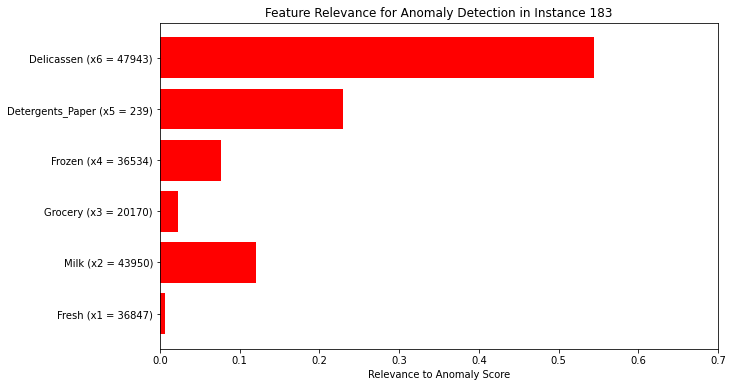

In [50]:
labels = [f'{col} (x{col_idx + 1} = {df.iloc[instance_index, col_idx]})' for col_idx, col in enumerate(df_transformed.columns)]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(labels, R, color='red')
plt.xlabel('Relevance to Anomaly Score')
plt.title('Feature Relevance for Anomaly Detection in Instance ' + str(instance_index))
plt.xlim((0, 0.7))  
plt.show()

We see that for instance 183, the extreme amount of spending (47943) on delicatessen contributed main evidence for its high outlierness scores(0.544 relevance score).
Moreover, the second determinant that is represented on its high outlier score was detergents/papers (0.229) with the reasoning of significantly lower spending.

In [52]:
top_indices = df_c['Outlier Score'].nlargest(10).index
df_c.loc[top_indices]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Outlier Score
183,Horeca,Other Region,36847,43950,20170,36534,239,47943,1.000000
338,Horeca,Oporto,3,333,7021,15601,15,550,0.995751
154,Horeca,Other Region,622,55,137,75,7,8,0.693723
228,Horeca,Lisbon,1869,577,572,950,4762,203,0.632297
181,Horeca,Other Region,112151,29627,18148,16745,4948,8550,0.611755
65,Retail,Other Region,85,20959,45828,36,24231,1423,0.602905
95,Horeca,Other Region,3,2920,6252,440,223,709,0.573502
325,Horeca,Oporto,32717,16784,13626,60869,1272,5609,0.566600
75,Horeca,Other Region,20398,1137,3,4407,3,975,0.553943
71,Horeca,Other Region,18291,1266,21042,5373,4173,14472,0.553624


In [53]:
def analyze_top_outliers(df_transformed, df_c, gamma, top_n):
    top_indices = df_c['Outlier Score'].nlargest(top_n).index
    feature_contributions = np.zeros(df_transformed.shape[1])
    
    #for each instance in top 10, we get relevance score and normalize it by outlierness score
    for idx in top_indices:
        feature_contributions += compute_feature_relevance(df_transformed, df_c, gamma, idx) / df_c['Outlier Score'][idx]
    
    #averaging contributions
    average_contributions = feature_contributions / top_n
    
    print(f"Average contribution of features for the top {top_n} outliers (normalized):")
    for i in range(df_transformed.shape[1]):
        print(f'{df_transformed.columns[i]}: {average_contributions[i]:.3f}')
    

    labels = [f'{col}' for col in df_transformed.columns]
    plt.figure(figsize=(12, 8))
    plt.barh(labels, average_contributions, color='blue')
    plt.xlabel('Average Relevance')
    plt.title(f'Average Feature Relevance for Top {top_n} Outliers')
    plt.xlim((0, max(average_contributions) * 1.5))
    plt.show()

Average contribution of features for the top 10 outliers (normalized):
Fresh: 0.171
Milk: 0.178
Grocery: 0.151
Frozen: 0.224
Detergents_Paper: 0.139
Delicassen: 0.137


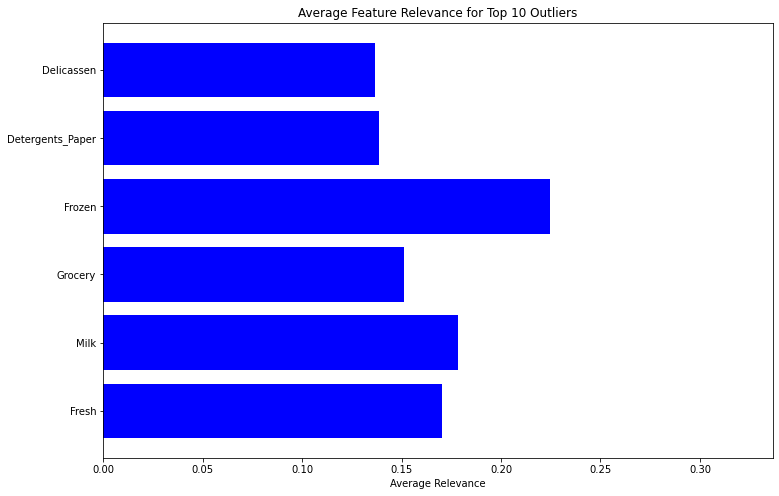

In [54]:
gamma = 1.0
top_n = 10
analyze_top_outliers(df_transformed, df_c, gamma, top_n)

We aimed to analyze which category was the main determinant for the high outlierness scores among the top 10 outliers. However, we needed to account for the fact that the outlierness scores for these top 10 instances varied widely, ranging from 0.553624 to 1. To accurately compare the contributions of features across instances with different outlierness scores, we normalized the contributions by each instance's outlierness score. This normalization ensures that the contributions are represented on a comparable scale, making it easier to identify the most influential categories for the high outlierness scores.

Based on the results of this analysis, we concluded that the **Frozen** category contributes higher significant evidence for the outlierness of these top instances compared to others.

In [55]:
def plot_individual_outliers(df_transformed, df_c, gamma, indices):
    #This function can handle any list of instances, but in this context,
    # we will use to visualize the top outliers relevance scores.
    
    for idx in indices:
        relevance_scores = compute_feature_relevance(df_transformed, df_c, gamma, idx)
        labels = [f'{col} (x{col_idx + 1} = {df.iloc[idx, col_idx]})' for col_idx, col in enumerate(df_transformed.columns)]
        
        
        plt.figure(figsize=(12, 8))
        plt.barh(labels, relevance_scores, color='green')
        plt.xlabel('Relevance')
        plt.title(f'Feature Relevance for Instance {idx}')
        plt.xlim((0, 0.6))
        plt.show()

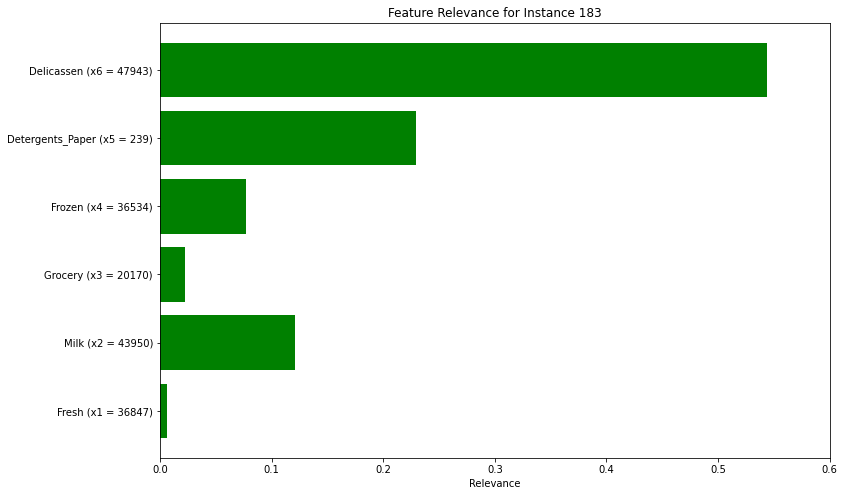

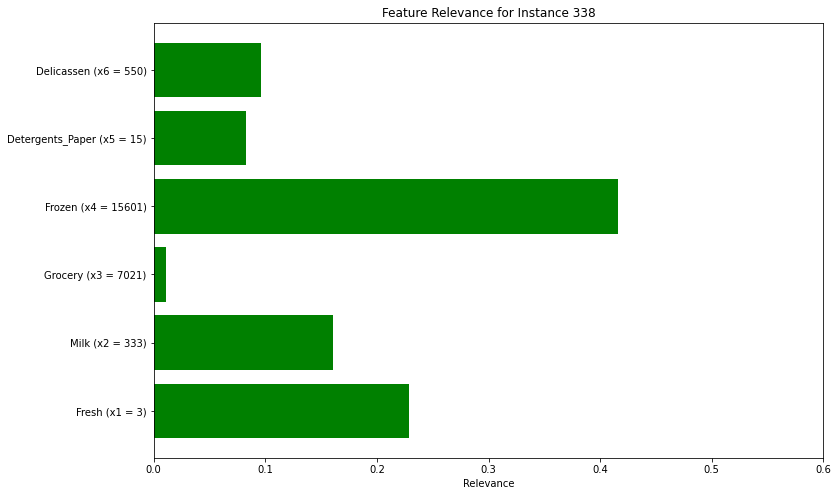

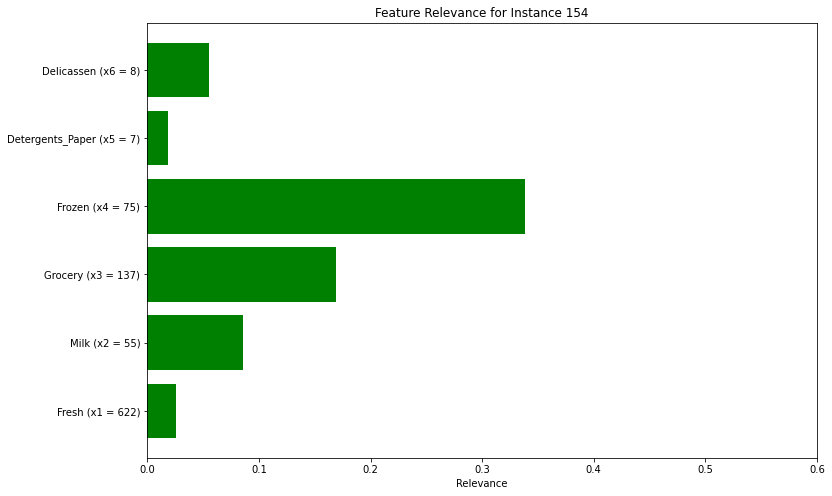

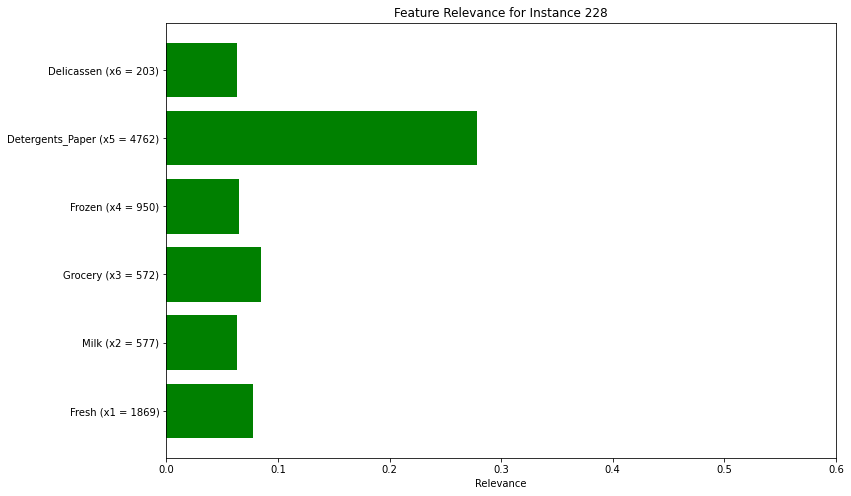

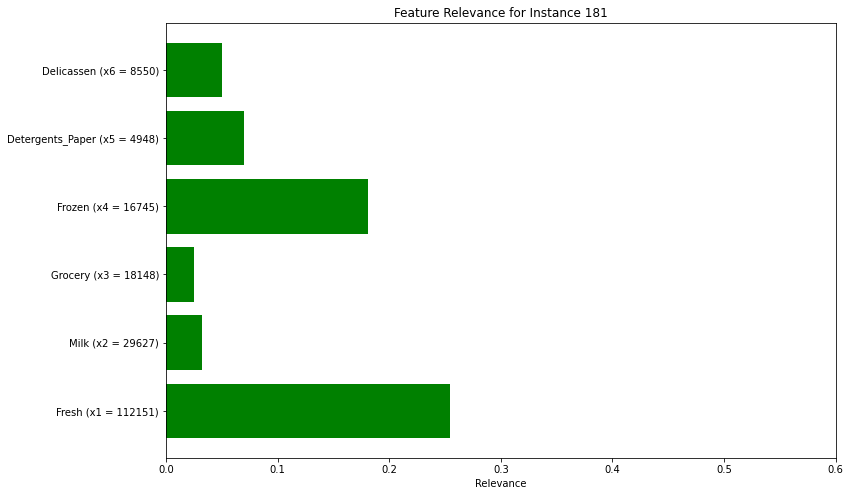

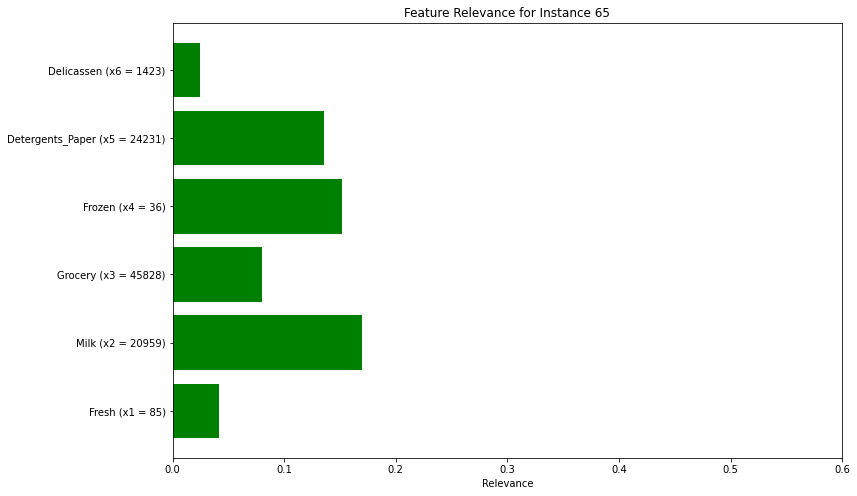

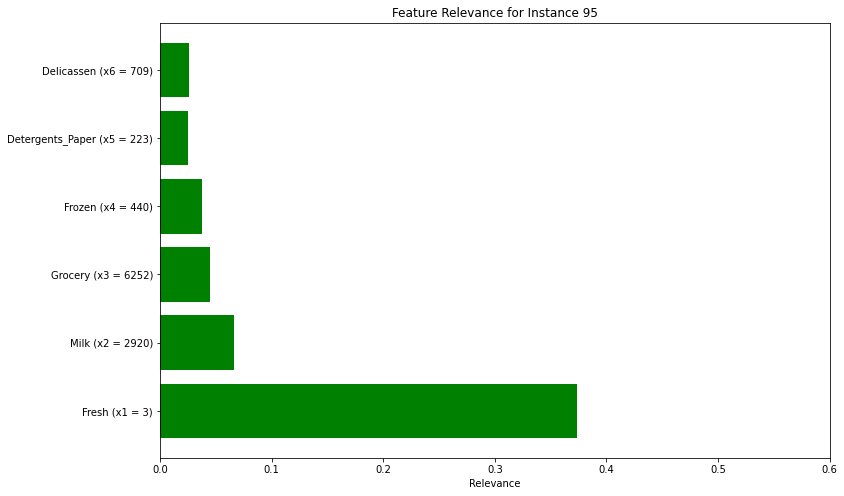

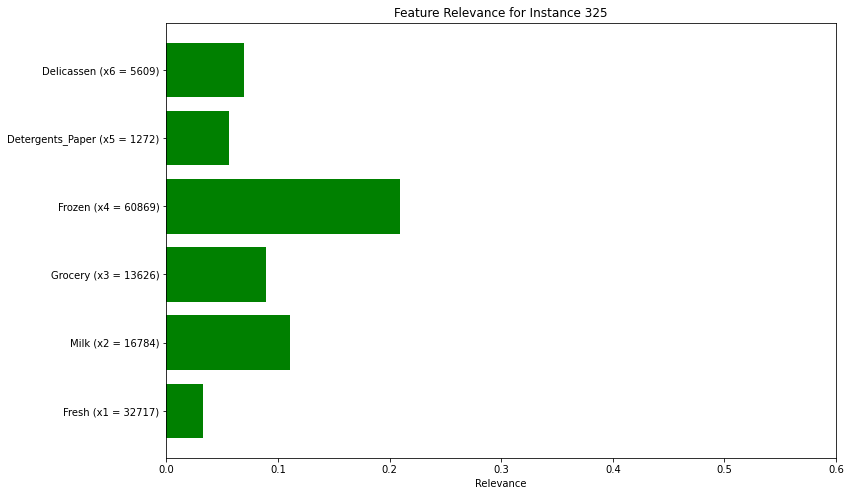

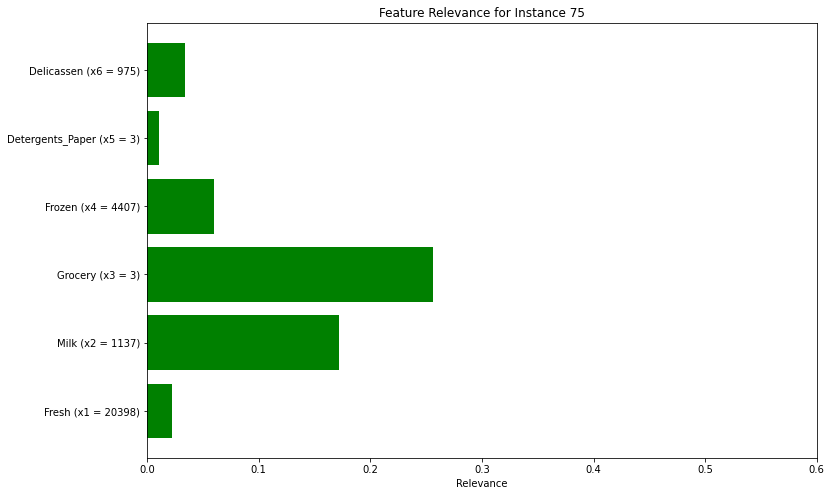

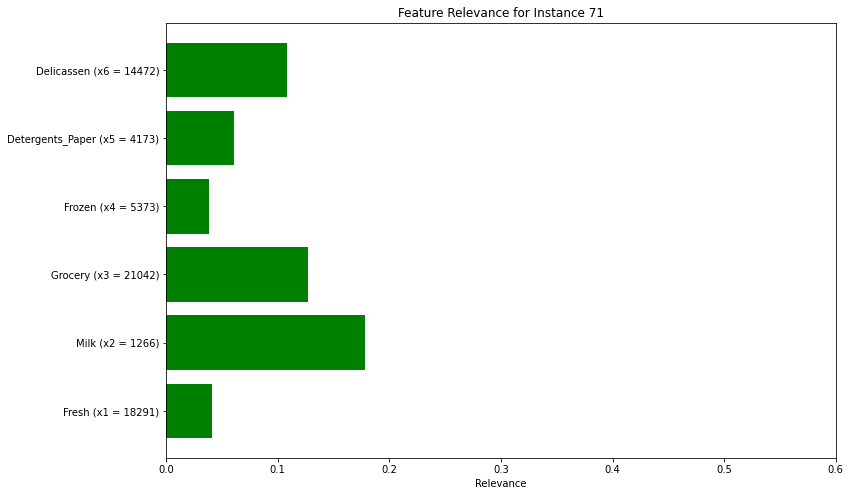

In [56]:
gamma = 1
top_n = 10  
top_indices = df_c['Outlier Score'].nlargest(top_n).index # getting the indices of the top N outliers
plot_individual_outliers(df_transformed, df_c.drop(['Region', 'Channel'], axis=1), gamma, top_indices)

We extended the analysis of contribution of each input feature for outlierness of top 10 instances by examining each of them individually.<br>

For instance, consider the second most extreme outlier, instance **338**. As expected, the categories where spending behavior diverges significantly for this instance are strongly represented in the explanation of outlierness. Specifically, the categories Fresh, Milk, Frozen, Delicatessen, and Detergents/Paper contribute almost all the evidence for the outlierness score.<br>

Considering instance **154**, the spendings on categories are generally low. But, the extremely low spending in the Delicatessen and Detergents_Paper categories is underrepresented in the relevance scores, despite the fact that such low spending should contribute to outlierness. The main evidence for the outlierness score comes from the Frozen, Grocery, and Milk categories. This indicates that while the spending behavior in Delicatessen and Detergents_Paper is unusual, the more significant deviations in spending in Frozen, Grocery, and Milk have a greater impact on the outlierness score for this instance.